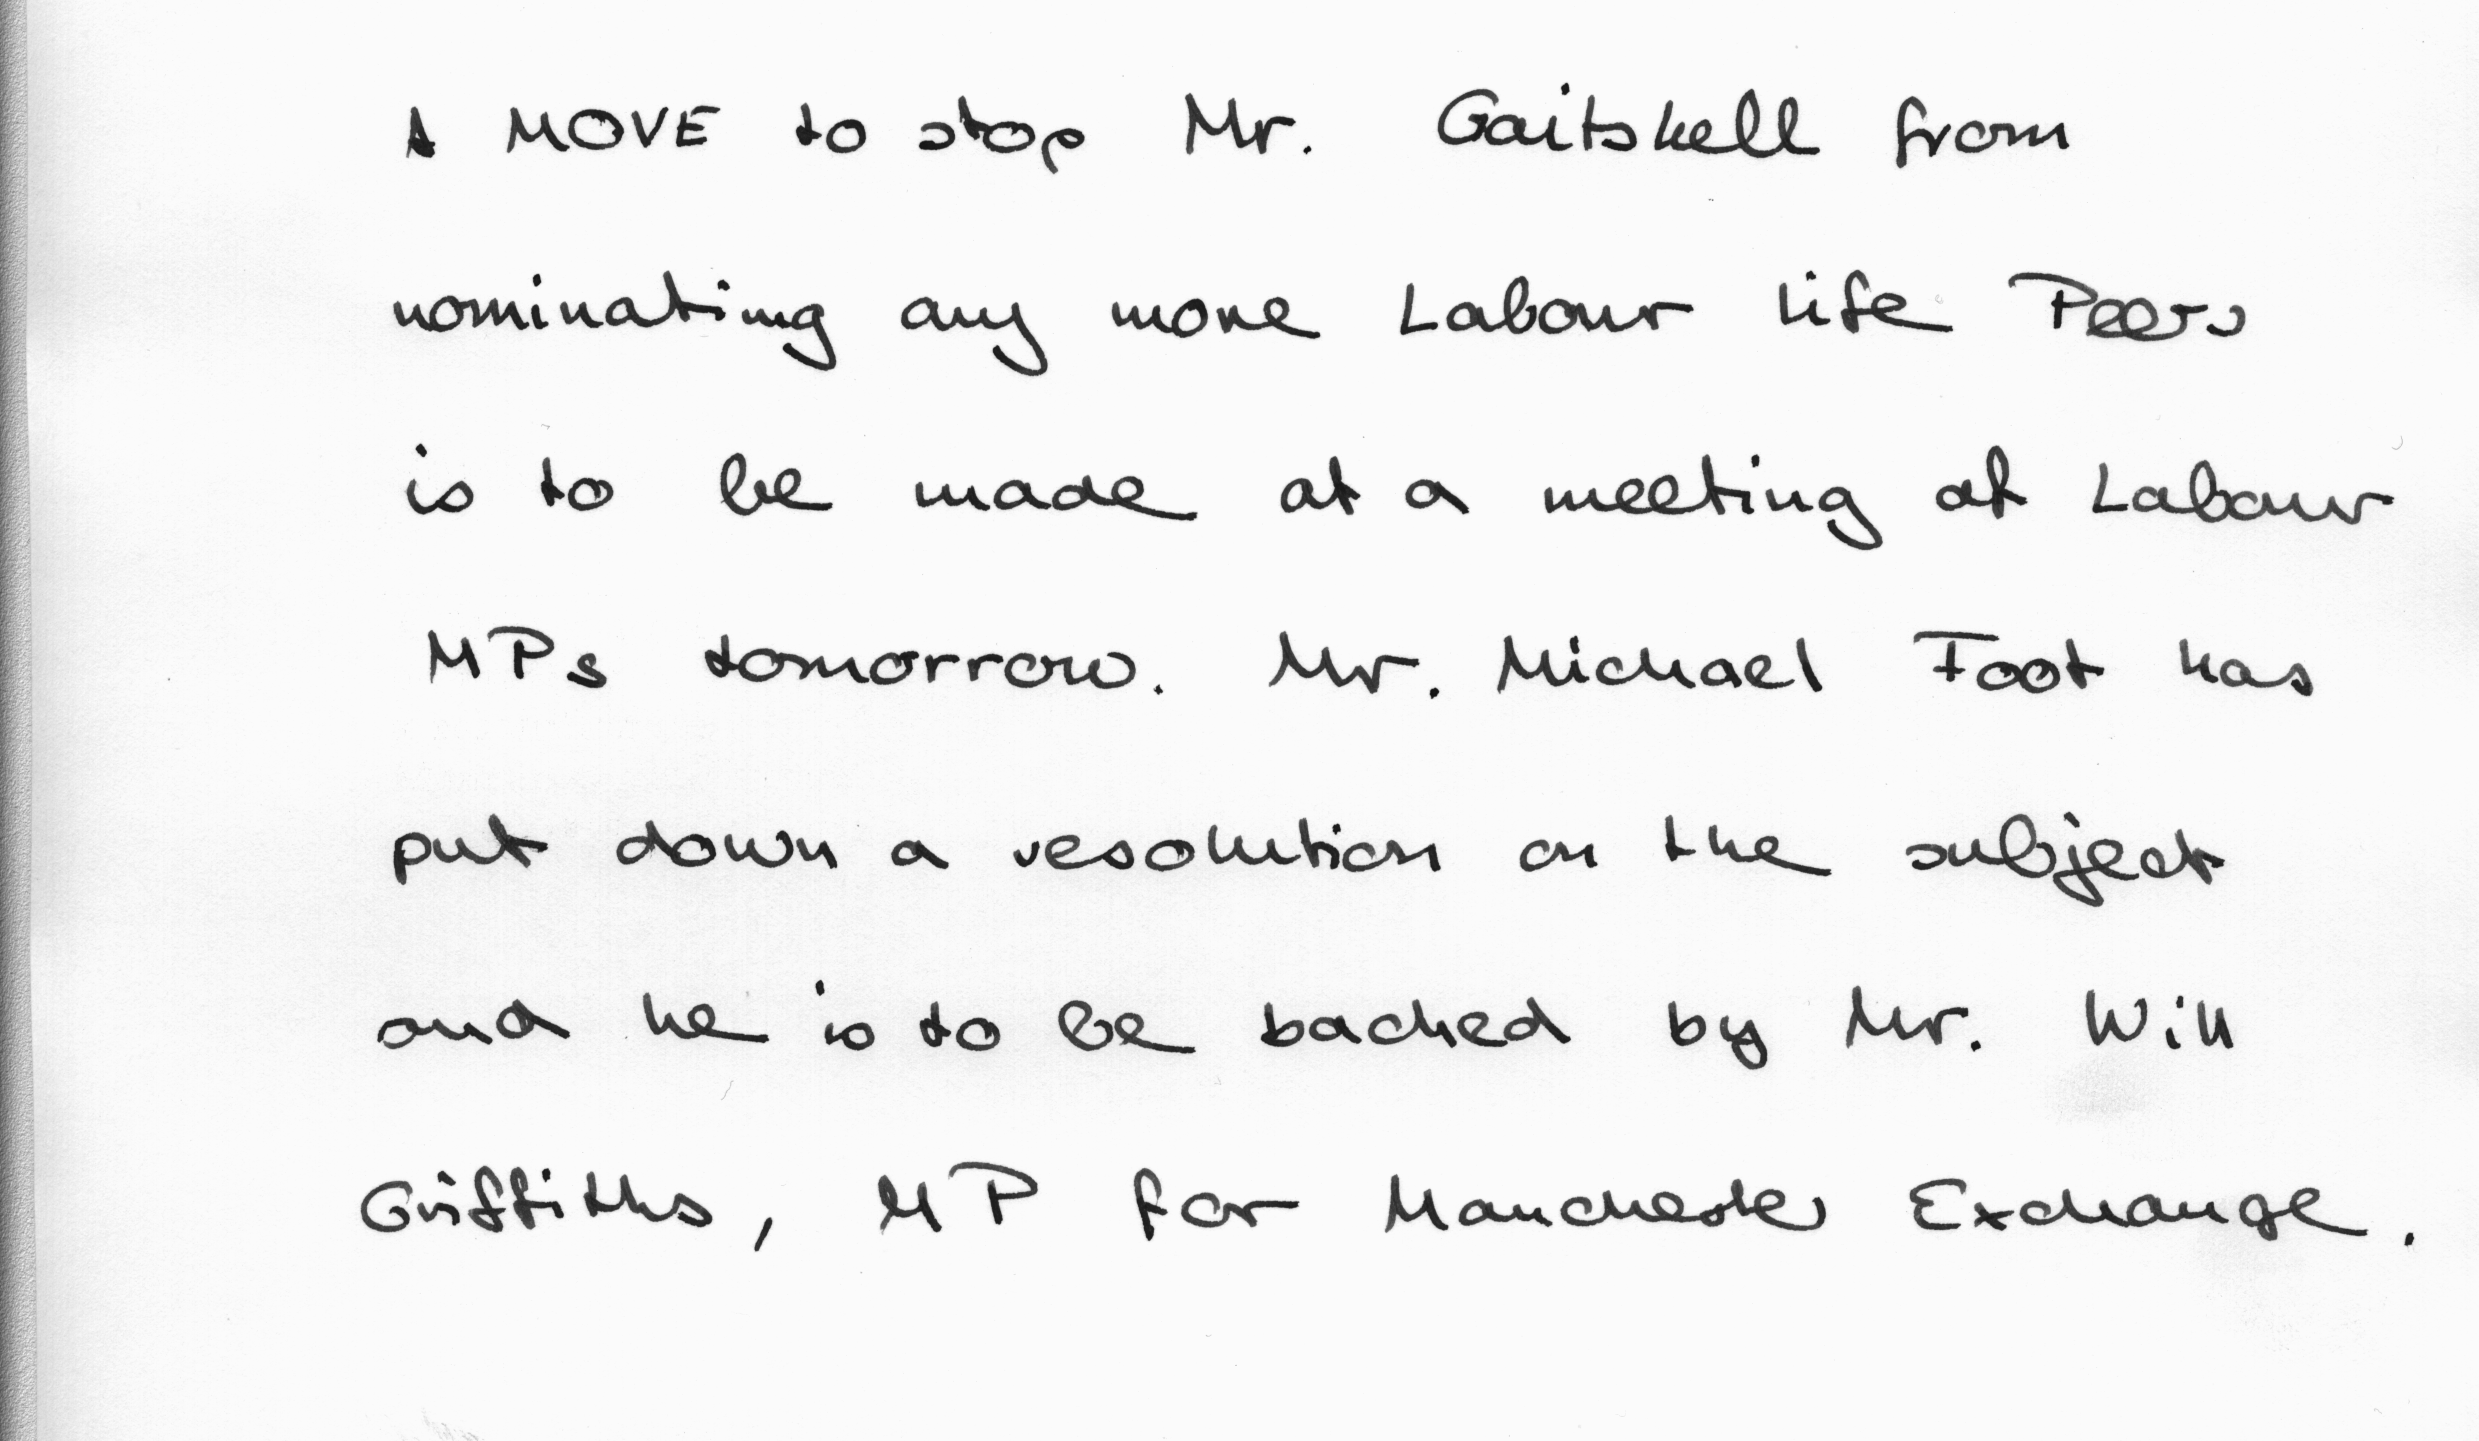

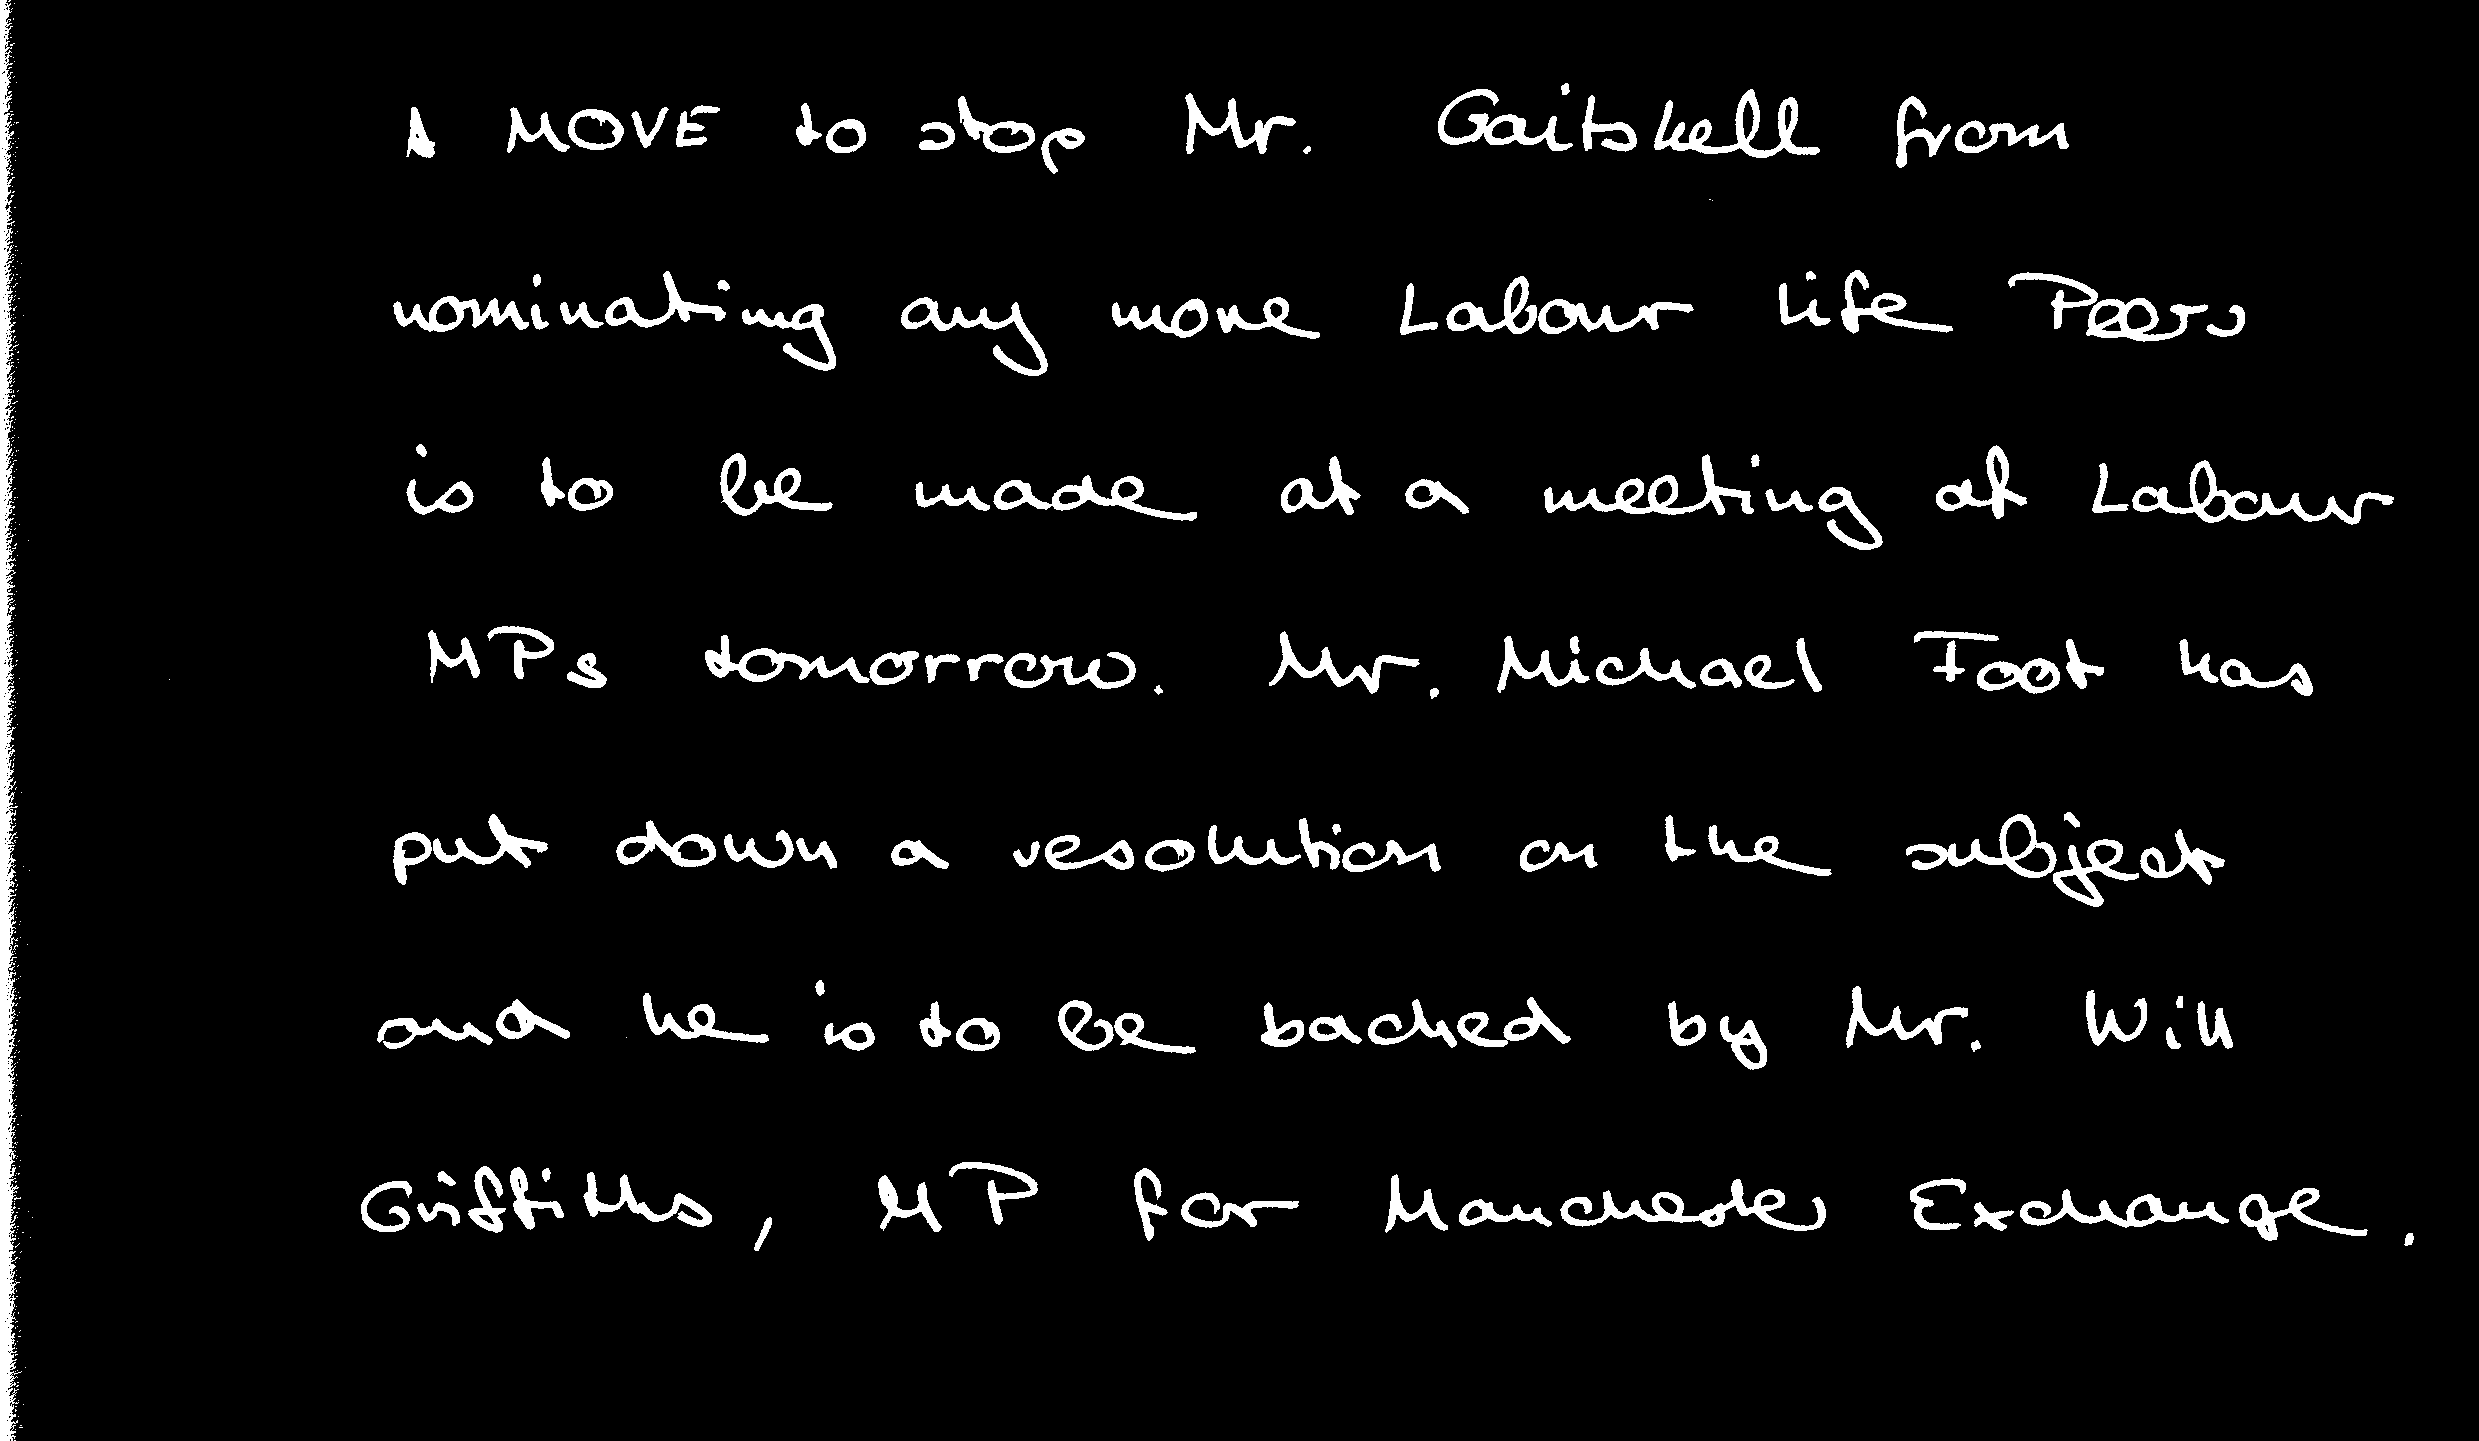

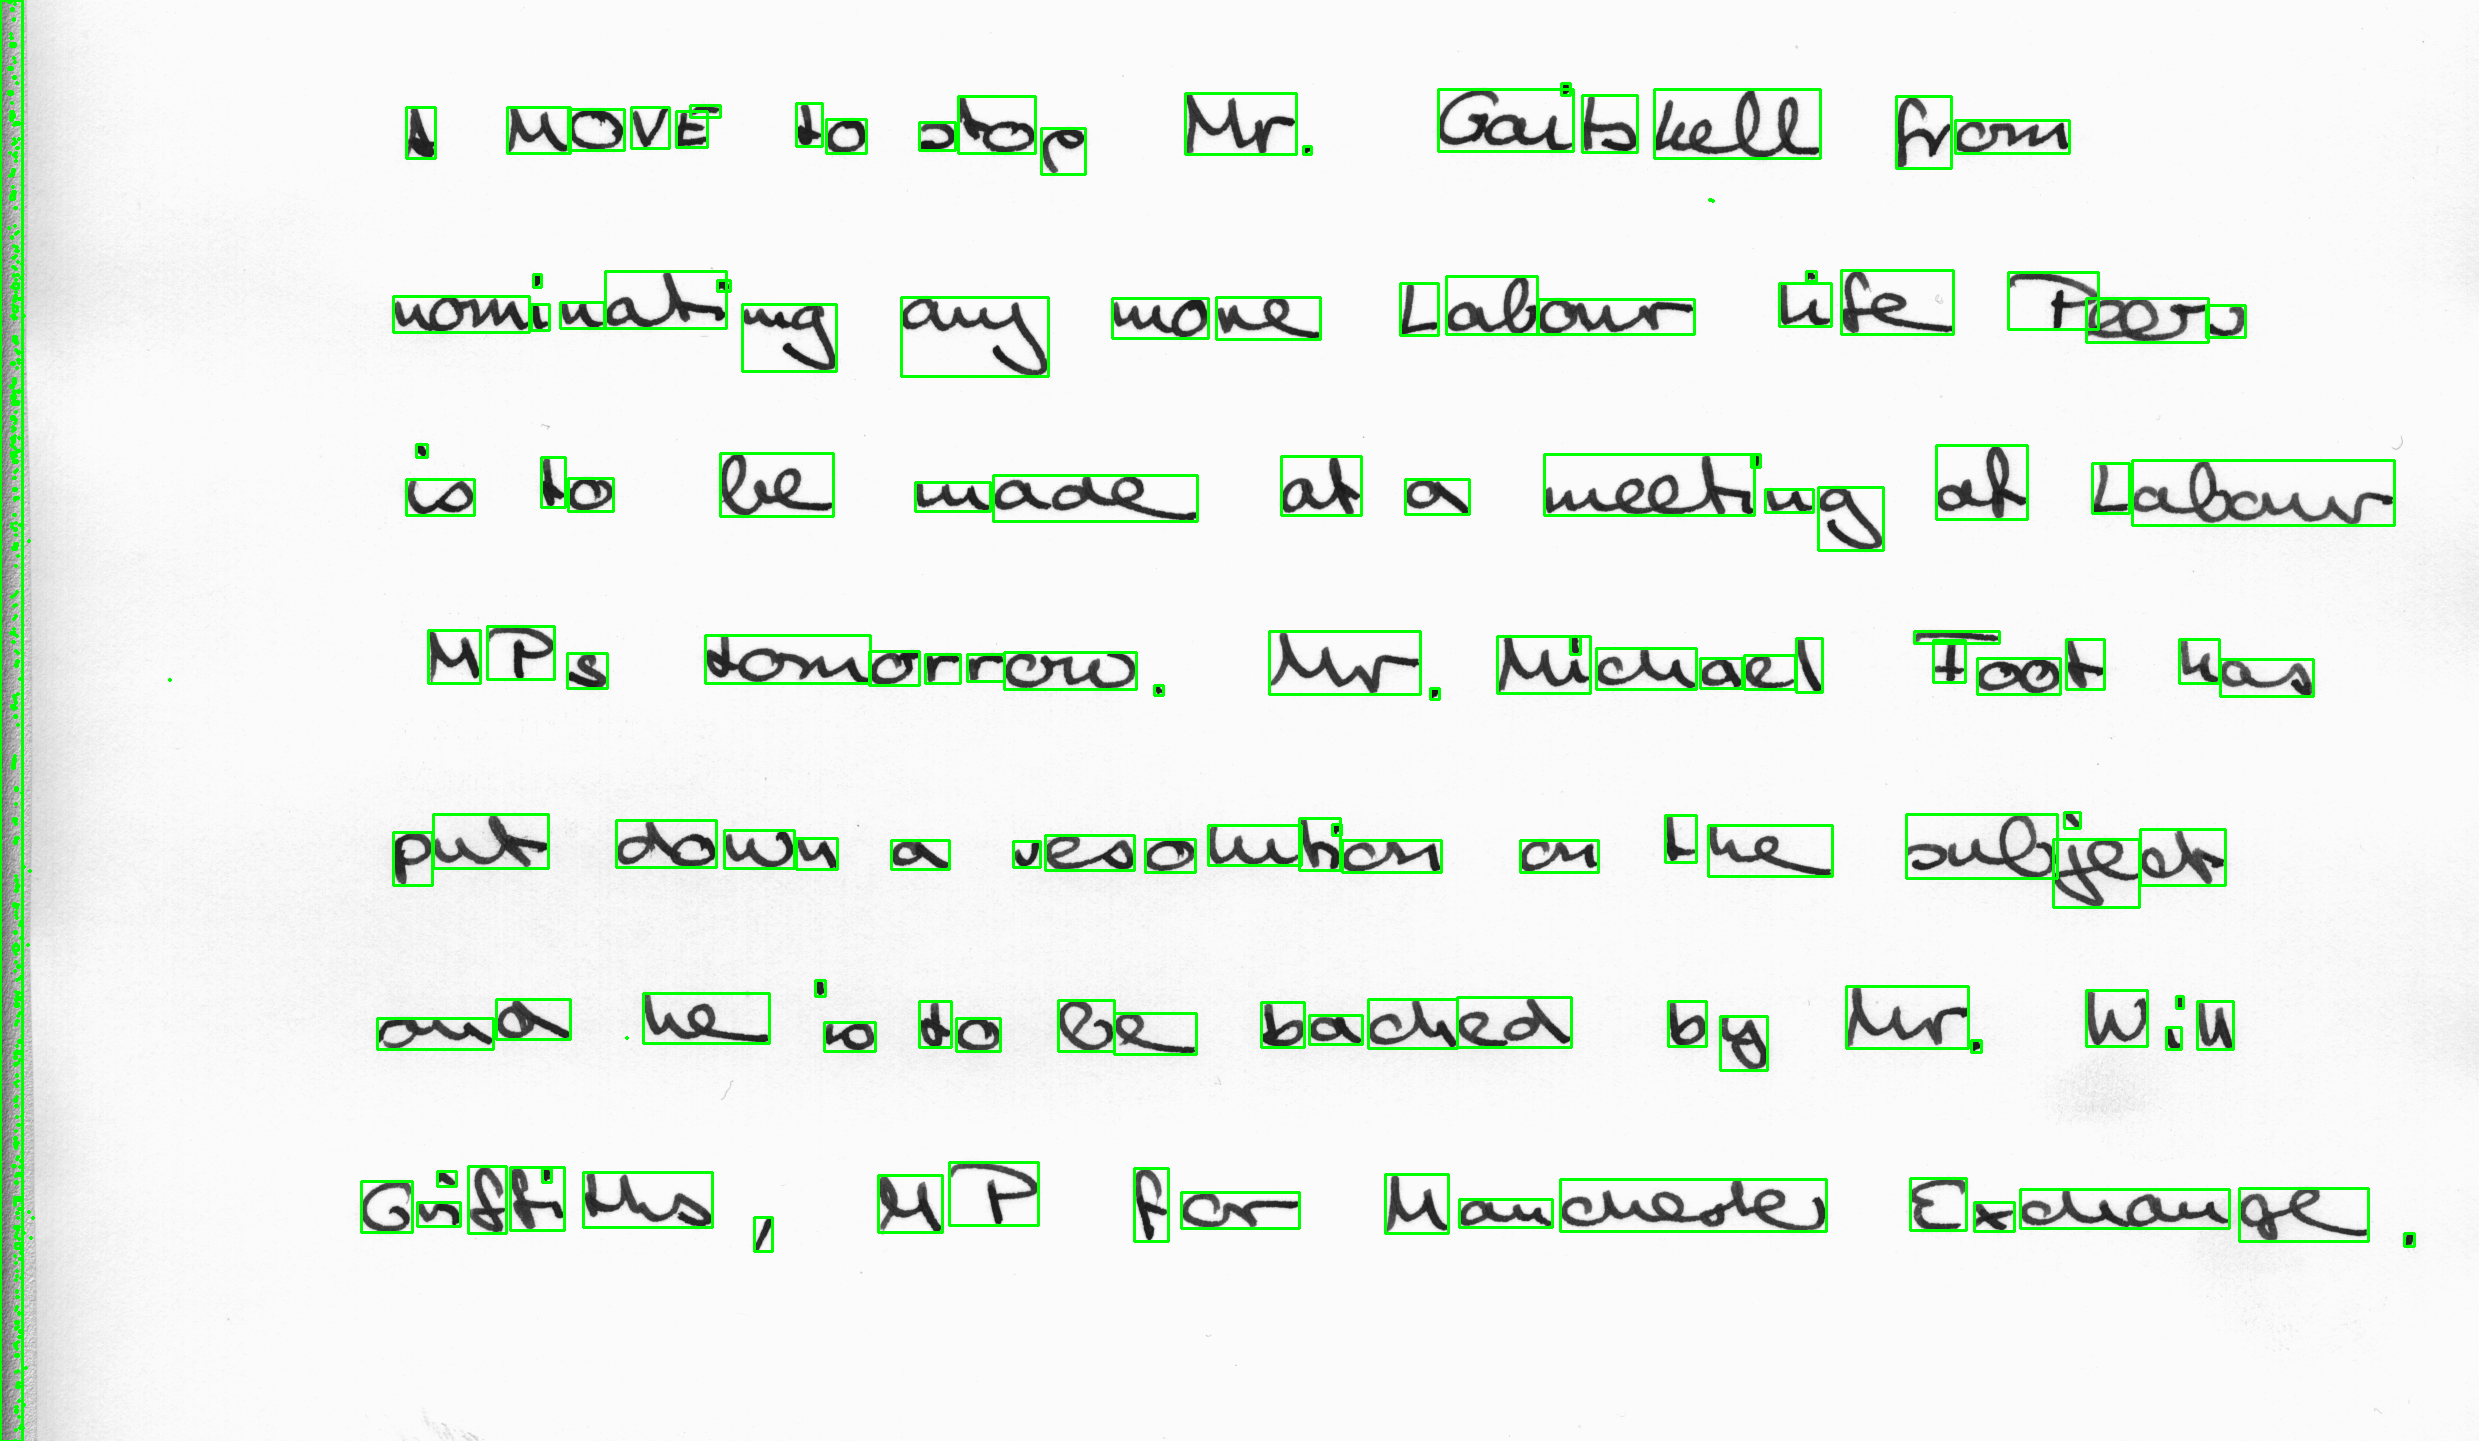

In [2]:
import cv2
from google.colab.patches import cv2_imshow

# Load image
image = cv2.imread('rept1.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Show grayscale image
cv2_imshow(gray)

# Apply thresholding to binarize the image
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Show thresholded (binarized) image
cv2_imshow(thresh)

# Find contours of connected components (words)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over contours and create bounding boxes
word_images = []
for cnt in contours:
    # Get bounding box for each contour
    x, y, w, h = cv2.boundingRect(cnt)

    # Crop the word from the image using the bounding box
    word_image = image[y:y+h, x:x+w]
    word_images.append(word_image)

    # Optionally, draw bounding boxes on the original image for visualization
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Show the final image with detected words highlighted
cv2_imshow(image)


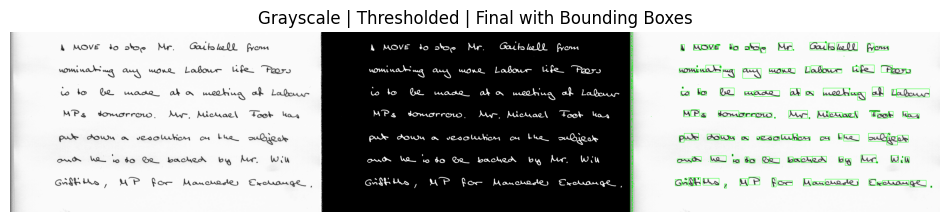

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Convert all images to BGR for concatenation, if needed (as grayscale and threshold images are single channel)
gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
thresh_bgr = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# Concatenate the grayscale, thresholded, and final images side by side
concatenated_image = np.concatenate((gray_bgr, thresh_bgr, image), axis=1)

# Display the concatenated image using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(concatenated_image, cv2.COLOR_BGR2RGB))
plt.title('Grayscale | Thresholded | Final with Bounding Boxes')
plt.axis('off')
plt.show()

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Load image
image = cv2.imread('report2.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to handle lighting variations
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Find contours of connected components (words)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store bounding boxes for each contour
bounding_boxes = []
for cnt in contours:
    if cv2.contourArea(cnt) > 100:  # Filter small contours based on area
        x, y, w, h = cv2.boundingRect(cnt)
        padding = 5  # Adjust padding slightly for a tighter fit
        x = max(x - padding, 0)
        y = max(y - padding, 0)
        w = min(w + 2 * padding, image.shape[1] - x)
        h = min(h + 2 * padding, image.shape[0] - y)
        bounding_boxes.append([x, y, w, h])

# Function to check if two boxes overlap or are very close (with a proximity margin)
def overlap_or_close(box1, box2, margin=0):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return not (x1 + w1 + margin < x2 or x2 + w2 + margin < x1 or y1 + h1 + margin < y2 or y2 + h2 + margin < y1)

# Merge overlapping or close rectangles
def merge_boxes(boxes):
    merged_boxes = []
    while boxes:
        box = boxes.pop(0)
        to_merge = [box]
        for other_box in boxes:
            if box==other_box:
              continue
            if overlap_or_close(box, other_box):
                to_merge.append(other_box)
                boxes.remove(other_box)
        x_min = min([b[0] for b in to_merge])
        y_min = min([b[1] for b in to_merge])
        x_max = max([b[0] + b[2] for b in to_merge])
        y_max = max([b[1] + b[3] for b in to_merge])
        merged_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])
    return merged_boxes

# Merge overlapping/close bounding boxes
merged_boxes = merge_boxes(bounding_boxes)

# **TROCR**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


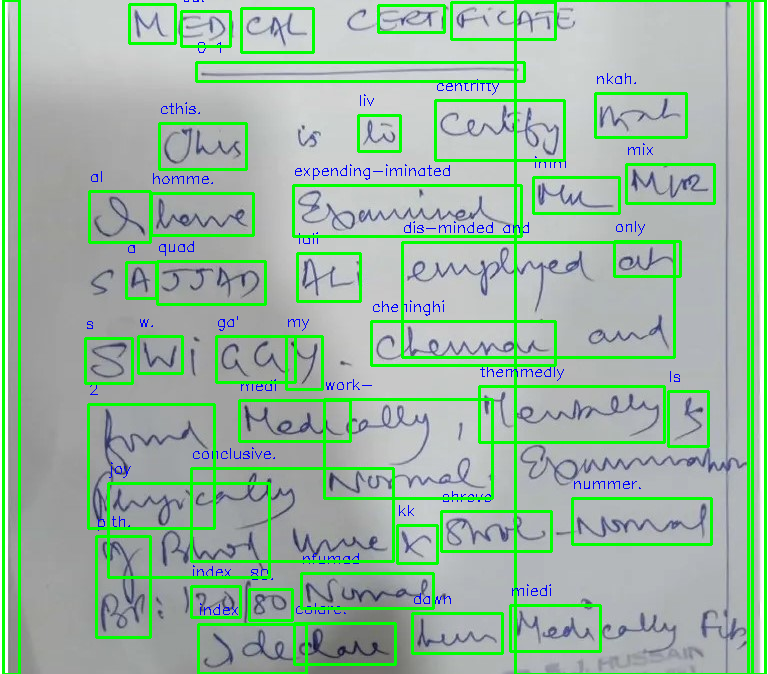

In [6]:
# Load TrOCR model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# Function to recognize text in a cropped region
def recognize_text(cropped_image):
    pil_image = Image.fromarray(cropped_image).convert('RGB')
    pixel_values = processor(pil_image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Prepare to write extracted texts to a file
extracted_texts = []

# Process each merged box, crop the image, and apply TrOCR
for (x, y, w, h) in merged_boxes:
    # Crop the image for the current bounding box
    cropped_img = image[y:y+h, x:x+w]

    # Convert the cropped image to grayscale (for better OCR accuracy)
    cropped_img_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    # Use TrOCR to recognize the text in the cropped image
    recognized_text = recognize_text(cropped_img_gray)

    # Store recognized text in the list
    extracted_texts.append(recognized_text)

    # Draw the bounding box and recognized text on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, recognized_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Write extracted texts to a text file
with open('extracted_texts.txt', 'w') as f:
    for text in extracted_texts:
        f.write(text + '\n')

# Display the final image with bounding boxes and recognized text
cv2_imshow(image)


# **EasyOCR**

In [7]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 22.3 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

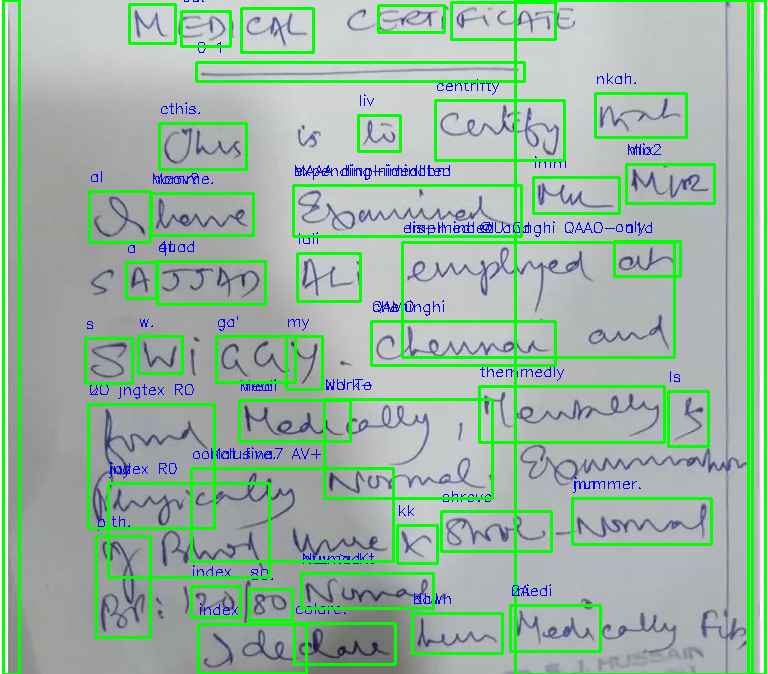

In [8]:
import easyocr

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])  # Specify the languages you want to support

# Prepare to write extracted texts and their positions to a file
extracted_texts = []

# Process each merged box, crop the image, and apply EasyOCR
for (x, y, w, h) in merged_boxes:
    # Crop the image for the current bounding box
    cropped_img = image[y:y+h, x:x+w]

    # Use EasyOCR to recognize the text in the cropped image
    results = reader.readtext(cropped_img)

    # Combine recognized texts from the results
    recognized_text = ' '.join([result[1] for result in results])

    # Store recognized text with coordinates in the list
    extracted_texts.append(f"Bounding Box: ({x}, {y}, {w}, {h}) -> Text: {recognized_text.strip()}")

    # Draw the bounding box and recognized text on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, recognized_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Write extracted texts with positions to a text file
with open('extracted_texts_with_positions.txt', 'w') as f:
    for entry in extracted_texts:
        f.write(entry + '\n')

# Display the final image with bounding boxes and recognized text
cv2_imshow(image)
